### This script classifies the drugs resulting from the drug proximity analysis into estrogen- or testosterone related for collaborator Taylor Simonian.

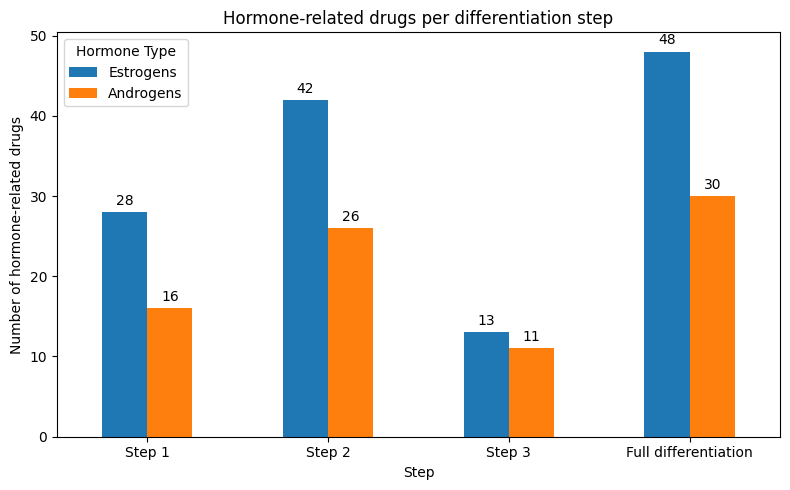

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load the CSV files ===
step1_df = pd.read_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/significant_drugs_whole_1000_step1_moa.csv")
step2_df = pd.read_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/significant_drugs_whole_1000_step2_moa.csv")
step3_df = pd.read_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/significant_drugs_whole_1000_step3_moa.csv")
full_diff_df = pd.read_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/significant_drugs_whole_1000_full_diff_moa.csv")

# === Step 2: Define hormone-related keyword lists ===
estrogen_keywords = [
    "estradiol", "estrogen", "estrone", "oestradiol", "oestrone", 
    "selective estrogen", "serm", "conjugated estrogen", "ethinylestradiol", 
    "estetrol", "estriol", "bazedoxifene", "raloxifene", "tamoxifen", 
    "clomifene", "toremifene", "ospemifene", "elacestrant", "lasofoxifene", 
    "dienestrol", "quinestrol", "fulvestrant"
]

androgen_keywords = [
    "testosterone", "androgen", "dht", "dihydrotestosterone", "methyltestosterone", 
    "danazol", "testosterone cypionate", "testosterone enanthate", 
    "nandrolone", "oxandrolone", "fluoxymesterone", "stanozolol"
]

# === Step 3: Define classification function ===
def classify_hormone_related_drugs(df):
    moa_cols = [col for col in df.columns if "moa" in col.lower() or "mechanism" in col.lower()]
    combined_moa = df[moa_cols].astype(str).apply(lambda x: " ".join(x), axis=1)

    est_mask = combined_moa.str.lower().str.contains("|".join(estrogen_keywords))
    and_mask = combined_moa.str.lower().str.contains("|".join(androgen_keywords))

    estrogens = df[est_mask][["Drug", *moa_cols]]
    androgens = df[and_mask][["Drug", *moa_cols]]

    return estrogens, androgens

# === Step 4: Classify for each step ===
step1_estrogens, step1_androgens = classify_hormone_related_drugs(step1_df)
step2_estrogens, step2_androgens = classify_hormone_related_drugs(step2_df)
step3_estrogens, step3_androgens = classify_hormone_related_drugs(step3_df)
full_estrogens, full_androgens = classify_hormone_related_drugs(full_diff_df)

# === Step 5: Summarise output ===
summary_hormones = {
    "Step 1": {
        "Estrogens": (len(step1_estrogens), sorted(step1_estrogens["Drug"].unique().tolist())),
        "Androgens": (len(step1_androgens), sorted(step1_androgens["Drug"].unique().tolist()))
    },
    "Step 2": {
        "Estrogens": (len(step2_estrogens), sorted(step2_estrogens["Drug"].unique().tolist())),
        "Androgens": (len(step2_androgens), sorted(step2_androgens["Drug"].unique().tolist()))
    },
    "Step 3": {
        "Estrogens": (len(step3_estrogens), sorted(step3_estrogens["Drug"].unique().tolist())),
        "Androgens": (len(step3_androgens), sorted(step3_androgens["Drug"].unique().tolist()))
    },
    "Full differentiation": {
        "Estrogens": (len(full_estrogens), sorted(full_estrogens["Drug"].unique().tolist())),
        "Androgens": (len(full_androgens), sorted(full_androgens["Drug"].unique().tolist()))
    }
}

# === Step 6: Convert summary to DataFrame and save to CSV ===
def summary_to_df(summary_dict):
    rows = []
    for step, groups in summary_dict.items():
        for hormone, (count, drugs) in groups.items():
            for drug in drugs:
                rows.append({
                    "Step": step,
                    "Hormone Type": hormone,
                    "Drug": drug
                })
    return pd.DataFrame(rows)

summary_df = summary_to_df(summary_hormones)
summary_df.to_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/hormone_drug_summary.csv", index=False)

# === Step 7: Create bar plot and save ===
plot_data = summary_df.groupby(["Step", "Hormone Type"])["Drug"].nunique().unstack()
plot_data = plot_data[["Estrogens", "Androgens"]]  # Ensure consistent column order
plot_data = plot_data.reindex(["Step 1", "Step 2", "Step 3", "Full differentiation"])

ax = plot_data.plot(kind='bar', figsize=(8, 5))
plt.ylabel("Number of hormone-related drugs")
plt.title("Hormone-related drugs per differentiation step")
plt.xticks(rotation=0)
plt.tight_layout()

# Add count labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.savefig("../results/humanPVATsn/network_analysis/proximity_significant_drugs/hormone_drug_barplot.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load drug data with MoA ===
step1_df = pd.read_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/significant_drugs_whole_1000_step1_moa.csv")
step2_df = pd.read_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/significant_drugs_whole_1000_step2_moa.csv")
step3_df = pd.read_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/significant_drugs_whole_1000_step3_moa.csv")
full_df  = pd.read_csv("../results/humanPVATsn/network_analysis/proximity_significant_drugs/significant_drugs_whole_1000_full_diff_moa.csv")

# === Step 2: Define therapeutic categories and keywords ===
categories = {
    "Sex hormones": [
        "estradiol", "estrogen", "estrone", "estriol", "progesterone", "testosterone", "androgen",
        "tamoxifen", "clomifene", "raloxifene", "fulvestrant", "SERMs", "SERDs", "bazedoxifene", 
        "ospemifene", "toremifene"
    ],
    "Steroids (glucocorticoids/corticosteroids)": [
        "glucocorticoid", "corticosteroid", "dexamethasone", "betamethasone", "prednisone", 
        "prednisolone", "hydrocortisone", "fludrocortisone", "triamcinolone"
    ],
    "Growth hormone / insulin-like": [
        "growth hormone", "somatropin", "GH", "insulin", "IGF", "mecasermin", "glargine", "detemir"
    ],
    "Alzheimer’s / amyloid-β": [
        "amyloid", "cholinesterase", "donepezil", "rivastigmine", "galantamine", "memantine", 
        "monoclonal", "PET tracer", "Alzheimer"
    ],
    "CNS (GABA / dopamine)": [
        "GABA", "dopamine", "benzodiazepine", "antipsychotic", "barbiturate", "neuroleptic", 
        "schizophrenia", "psychoactive"
    ],
    "PPARγ agonists": [
        "PPAR", "rosiglitazone", "pioglitazone", "thiazolidinedione"
    ],
    "Adrenergic agonists": [
        "adrenergic", "beta-3", "β3", "mirabegron", "isoproterenol", "sympathomimetic"
    ]
}

default_category = "Other / Unclassified"

# === Step 3: Function to classify drugs by category based on MoA ===
def classify_moa(drug_df):
    def assign_category(moa_text):
        moa_text = str(moa_text).lower()
        for category, keywords in categories.items():
            if any(keyword.lower() in moa_text for keyword in keywords):
                return category
        return default_category

    drug_df["Category"] = drug_df["MoA"].apply(assign_category)
    return drug_df

# === Step 4: Classify each step ===
step1_classified = classify_moa(step1_df)
step2_classified = classify_moa(step2_df)
step3_classified = classify_moa(step3_df)
full_classified  = classify_moa(full_df)

# === Step 5: Pie chart function ===
def plot_pie(data, title, filename):
    counts = data["Category"].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=140)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# === Step 6: Generate and save pie charts ===
plot_pie(step1_classified, "Drug categories - step 1", "../results/humanPVATsn/network_analysis/proximity_significant_drugs/step1_pie_chart.png")
plot_pie(step2_classified, "Drug categories - step 2", "../results/humanPVATsn/network_analysis/proximity_significant_drugs/step2_pie_chart.png")
plot_pie(step3_classified, "Drug categories - step 3", "../results/humanPVATsn/network_analysis/proximity_significant_drugs/step3_pie_chart.png")
plot_pie(full_classified,  "Drug categories - full differentiation", "../results/humanPVATsn/network_analysis/proximity_significant_drugs/full_diff_pie_chart.png")